# Gen AI Demo

## Overview
Este notebook mostra diferente cénarios de como o Gemini pode ser utilizado no dia a dia dos desenvolvedores.

## Custos
Este tutorial usa componentes faturáveis ​​do Google Cloud:

* Vertex AI
* BigQuery

Saiba mais sobre [preços da Vertex AI](https://cloud.google.com/vertex-ai/pricing) e [BigQuery](https://cloud.google.com/bigquery/pricing).

Use a [calculadora de preços](https://cloud.google.com/products/calculator/)
para gerar uma estimativa de custo com base no uso projetado.

# Setup

### Instalar o SDK da Vertex AI e BigQuery para Python

In [ ]:
! pip3 install --upgrade --user google-cloud-aiplatform google-cloud-bigquery

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.7/236.7 kB 15.2 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Reinicie o Runtime
Para usar os pacotes recém-instalados neste runtime do Jupyter, você deve reiniciar o runtime. Você pode fazer isso executando a seguinte célula, que irá reiniciar o kernel atual.

In [ ]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your notebook environment (Colab only)
Se você estiver executando este notebook no Google Colab, execute a célula a seguir para autenticar seu ambiente. Esta etapa não é necessária se você estiver usando o [Vertex AI Workbench](https://cloud.google.com/vertex-ai-notebooks?hl=en).

In [ ]:
import sys

# Additional authentication is required for Google Colab
if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Defina as informações do projeto do Google Cloud e inicialize o Vertex AI
Inicialize o SDK da Vertex AI para Python para seu projeto:

In [ ]:
# Define project information
PROJECT_ID = "[YOUR-PROJECT-ID]"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

BQ_PROJECT_ID = "[YOUR-PROJECT-ID]"  # @param {type:"string"}
BQ_LINKED_DATASET = "[YOUR-DATASET-NAME]"  # @param {type:"string"}
BQ_LINKED_TABLE = "[YOUR-TABLE-NAME]"  # @param {type:"string"}

# Initialize Vertex AI and BigQuery
from google.cloud import bigquery
import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)
client = bigquery.Client(project=BQ_PROJECT_ID)

### Import libraries

In [ ]:
from IPython.display import Markdown
from vertexai.generative_models import (
    GenerationConfig,
    GenerativeModel,
    Image,
    Part,
)

## Vamos o usar o Gemini 1.5 Pro
*Para algumas demos podem ser utilizados outros modelos*

In [ ]:
multimodal_model = GenerativeModel("gemini-1.5-pro-preview-0409")

## Definir funções auxiliares para imagens


In [ ]:
import http.client
import typing
import urllib.request

import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps


def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)


def get_image_bytes_from_url(image_url: str) -> bytes:
    with urllib.request.urlopen(image_url) as response:
        response = typing.cast(http.client.HTTPResponse, response)
        image_bytes = response.read()
    return image_bytes


def load_image_from_url(image_url: str) -> Image:
    image_bytes = get_image_bytes_from_url(image_url)
    return Image.from_bytes(image_bytes)


def display_content_as_image(content: str | Image | Part) -> bool:
    if not isinstance(content, Image):
        return False
    display_images([content])
    return True


def display_content_as_video(content: str | Image | Part) -> bool:
    if not isinstance(content, Part):
        return False
    part = typing.cast(Part, content)
    file_path = part.file_data.file_uri.removeprefix("gs://")
    video_url = f"https://storage.googleapis.com/{file_path}"
    IPython.display.display(IPython.display.Video(video_url, width=600))
    return True


def print_multimodal_prompt(contents: list[str | Image | Part]):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if display_content_as_image(content):
            continue
        if display_content_as_video(content):
            continue
        print(content)

## Definir função auxiliar para gerar SQL

In [ ]:
import re


# Strip text to include only the SQL code block with
def sanitize_output(text: str) -> str:
    # Strip whitespace and any potential backticks enclosing the code block
    text = text.strip()
    regex = re.compile(r"^\s*```(\w+)?|```\s*$")
    text = regex.sub("", text).strip()

    # Find and remove any trailing quote without corresponding opening quote
    if re.search(r'^[^"]*"$', text):
        text = text[:-1]
    # Find and remove any leading quote without corresponding closing quote
    if re.search(r'^"[^"]*$', text):
        text = text[1:]

    return text


# Call model using prompt and pre-defined parameters
def generate_sql(
    model,
    contents,
    temperature: float = 0.2,
    max_output_tokens: int = 1024,
    top_k: int = 40,
    top_p: float = 0.8,
) -> str:
    print("Generating SQL...")
    print("Number of input tokens: " + str(len(prompt)))

    # response = model.predict(
    #     prompt,
    #     temperature=temperature,
    #     max_output_tokens=max_output_tokens,
    #     top_k=top_k,
    #     top_p=top_p,
    # )
    response_sql = model.generate_content(contents)

    text = response_sql.text
    print("Number of output tokens: " + str(len(text)))
    print("Response:")
    print(text)

    # Strip text to include only the SQL code block
    text = sanitize_output(text)
    print("Response stripped:")
    print(text)

    return text

## Definir função auxiliar para executar SQL


In [ ]:
# Limit number of bytes processed as a guardrail for cost control
BQ_MAX_BYTES_BILLED = pow(2, 30)  # 1GB


def execute_sql(query: str):
    print("Executing SQL...")

    # Qualify table names with your project and dataset ID
    for table_name in BQ_TABLES:
        query = query.replace(
            table_name, f"{BQ_PROJECT_ID}.{BQ_LINKED_DATASET}.{table_name}"
        )

    print("Query:")
    print(query)

    # Validate the query by performing a dry run without incurring a charge
    job_config = bigquery.QueryJobConfig(use_query_cache=False, dry_run=True)
    try:
        response = client.query(query, job_config=job_config)
    except Exception as e:
        print("Error validating query:")
        print(e)
        return e

    print("Query will process {:.2f} KB.".format(response.total_bytes_processed / 1024))

    # Execute the query
    job_config = bigquery.QueryJobConfig(
        use_query_cache=False, maximum_bytes_billed=BQ_MAX_BYTES_BILLED
    )
    try:
        response = client.query(query)
        df = response.to_dataframe()
    except Exception as e:
        print("Error executing query:")
        print(e)
        return e

    return df

# Fazendo perguntas sobre um vídeo

Abaixo está outro exemplo para uso com o Gemini neste cenário de perguntas sobre um vídeo.

In [ ]:
prompt = """
Responda às seguintes perguntas usando apenas o vídeo:
Qual é o nome da pessoa principal?
Qual é a profissão da pessoa principal?
Quais são as principais funcionalidades do telefone destacadas?
Em que cidade isso foi gravado?
Forneça a resposta JSON.
"""

video = Part.from_uri(
    uri="gs://github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4",
    mime_type="video/mp4",
)
contents = [prompt, video]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Resposta--------")
for response in responses:
    print(response.text, end="")

-------Prompt--------

Responda às seguintes perguntas usando apenas o vídeo:
Qual é o nome da pessoa principal?
Qual é a profissão da pessoa principal?
Quais são as principais funcionalidades do telefone destacadas?
Em que cidade isso foi gravado?
Forneça a resposta JSON.




-------Resposta--------
```json
{
 "nome_pessoa_principal": "Saeka Shimada",
 "profissão_pessoa_principal": "Fotógrafa",
 "principais_funcionalidades_do_telefone": "Video Boost, Modo Noturno",
 "cidade_gravação": "Tóquio"
}
```

# Uma recomendação...

### Scenario

O cliente mostra sua sala:

|Customer photo |
|:-----:|
|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/rooms/spacejoy-c0JoR_-2x3E-unsplash.jpg" width="80%">  |



Abaixo estão quatro opções de cadeiras que o cliente está tentando decidir:

|Cadeira 1| Cadeira 2 | Cadeira 3 | Cadeira 4 |
|:-----:|:----:|:-----:|:----:|
| <img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg" width="80%">|<img src="https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg" width="80%">|


Como usar o Gemini 1.5 Pro, modelo multimodal, para ajudar o cliente a escolher a melhor opção e também explicar por quê?

### Compreensão visual com Gemini 1.5 Pro
Aqui você pedirá ao modelo Gemini 1.5 Pro para descrever uma sala em detalhes a partir de sua imagem. Para fazer isso você precisa **combinar texto e imagem em um único prompt**.

-------Prompt--------
Descreva o que é visível nesta sala e a atmosfera geral:


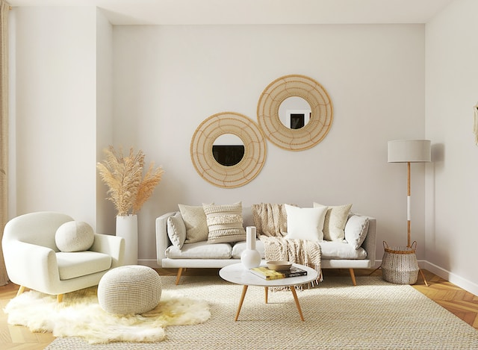


-------Response--------
A sala é decorada num estilo boémio moderno, com uma paleta de cores neutras e uma mistura de texturas. As paredes são de cor cinzento-claro e o chão é de madeira. A sala está mobilada com um sofá, uma poltrona, uma mesa de centro e um candeeiro de pé. O sofá e a poltrona são estofados com um tecido de cor clara e têm várias almofadas. A mesa de centro é feita de madeira e tem um tampo em mármore. O candeeiro de pé tem um abajur de tecido e um pé de madeira. A sala também tem vários elementos decorativos, incluindo dois espelhos de parede redondos, um vaso com erva-da-pampas e um tapete de pele de ovelha. A atmosfera geral da sala é acolhedora e convidativa.

In [ ]:
# urls for room images
room_image_url = "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/rooms/spacejoy-c0JoR_-2x3E-unsplash.jpg"

# load room images as Image Objects
room_image = load_image_from_url(room_image_url)

prompt = "Descreva o que é visível nesta sala e a atmosfera geral:"
contents = [
    prompt,
    room_image,
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

### Gerando recomendações abertas com base em conhecimento integrado (built-in)
Usando a mesma imagem, você pode pedir ao modelo que recomende **um móvel** que caiba nele junto com a descrição do ambiente.

Observe que o modelo pode escolher **qualquer móvel** recomendado neste caso, e pode fazê-lo a partir de seu único conhecimento integrado.

-------Prompt--------
Recomende uma nova peça de mobiliário para esta sala:


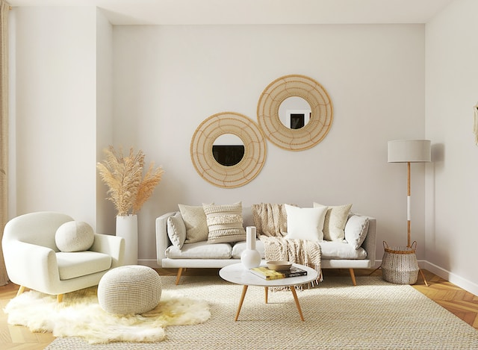

e explique o motivo em detalhes

-------Response--------
Uma ótima adição a esta sala de estar seria uma **mesa lateral de madeira com pernas finas**. Aqui está o porquê:

* **Estilo:** A sala tem uma estética boêmia moderna com tons neutros, materiais naturais e texturas aconchegantes. Uma mesa lateral de madeira complementaria este estilo, adicionando um toque de calor e textura. As pernas finas manteriam a sensação arejada e desimpedida do espaço.
* **Funcionalidade:** Uma mesa lateral oferece um local conveniente para colocar bebidas, livros ou itens decorativos. Ela também pode ser usada como superfície extra quando necessário.
* **Posicionamento:** A mesa lateral poderia ser colocada ao lado do sofá ou da cadeira, proporcionando fácil acesso para quem está sentado. Ela também poderia ser usada para criar uma área de estar separada, colocando-a perto da janela com uma cadeira e um abajur.
* **Material e cor:** Para combinar com a estética existente da sala, a mesa lateral deve ser

In [ ]:
prompt1 = "Recomende uma nova peça de mobiliário para esta sala:"
prompt2 = "e explique o motivo em detalhes"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

Na próxima célula, você pedirá ao modelo que recomende **um tipo de cadeira** que caiba nela junto com a descrição do ambiente.

Observe que o modelo pode escolher **qualquer tipo de cadeira** para recomendar neste caso.

In [ ]:
prompt1 = "Descreva esta sala:"
prompt2 = "e recomendar um tipo de cadeira que caiba nela"
contents = [prompt1, room_image, prompt2]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

## Generating recommendations based on provided images
Em vez de manter a recomendação aberta, você também pode fornecer uma lista de itens para o modelo escolher. Aqui você baixará algumas imagens de cadeiras e as definirá como opções para o modelo Gemini recomendar. Isto é particularmente útil para empresas de varejo que desejam fornecer recomendações aos usuários com base no tipo de quarto que possuem e nos itens disponíveis que a loja oferece.

-------Prompt--------
Considere as seguintes cadeiras:
cadeira 1:


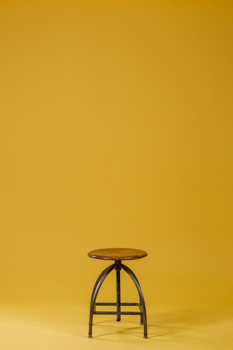

cadeira 2:


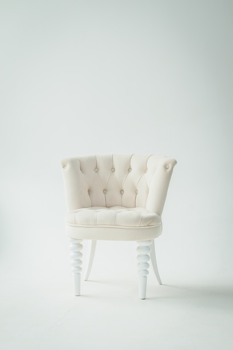

cadeira 3:


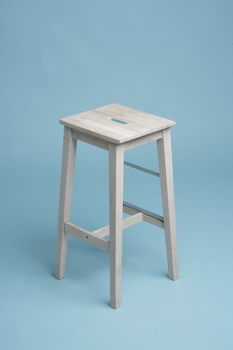

cadeira 4:


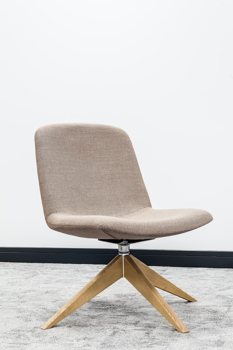

sala:


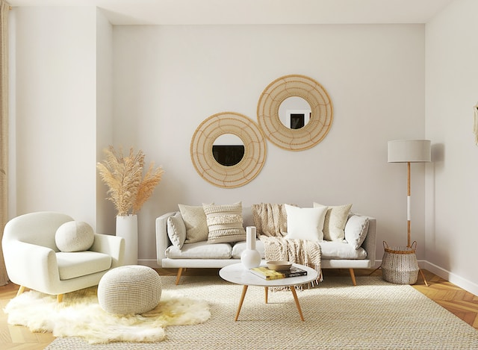

Você é um designer de interiores. Para cada cadeira, explique se seria adequada ao estilo da sala:

-------Response--------
## Análise das Cadeiras para a Sala:

**Estilo da Sala:** A sala apresenta um estilo contemporâneo com toques boho chic. Predominam tons neutros, materiais naturais (madeira, fibras) e texturas aconchegantes. As linhas são simples, com curvas suaves e alguns detalhes em metal ou vidro.

**Análise das Cadeiras:**

* **Cadeira 1:** O estilo industrial desta cadeira, com metal escuro e madeira rústica, **destoa** do estilo geral da sala. Seria mais adequada para um ambiente industrial ou rústico.
* **Cadeira 2:** O estilo clássico desta cadeira, com estofado capitonê e pés torneados, também **não se encaixa** na proposta da sala. Seria mais adequada para um ambiente clássico ou romântico.
* **Cadeira 3:** O estilo escandinavo desta cadeira, com madeira clara e linhas simples, **poderia funcionar** na sala, principalmente se estivesse acompanhada de outras peças no me

In [ ]:
# Download and display sample chairs
furniture_image_urls = [
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/cesar-couto-OB2F6CsMva8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/daniil-silantev-1P6AnKDw6S8-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/ruslan-bardash-4kTbAMRAHtQ-unsplash.jpg",
    "https://storage.googleapis.com/github-repo/img/gemini/retail-recommendations/furnitures/scopic-ltd-NLlWwR4d3qU-unsplash.jpg",
]

# Load furniture images as Image Objects
furniture_images = [load_image_from_url(url) for url in furniture_image_urls]

# To recommend an item from a selection, you will need to label the item number within the prompt.
# That way you are providing the model with a way to reference each image as you pose a question.
# Labelling images within your prompt also help to reduce hallucinations and overall produce better results.
contents = [
    "Considere as seguintes cadeiras:",
    "cadeira 1:",
    furniture_images[0],
    "cadeira 2:",
    furniture_images[1],
    "cadeira 3:",
    furniture_images[2],
    "cadeira 4:",
    furniture_images[3],
    "sala:",
    room_image,
    "Você é um designer de interiores. Para cada cadeira, explique se seria adequada ao estilo da sala:",
]

responses = multimodal_model.generate_content(contents, stream=True)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Response--------")
for response in responses:
    print(response.text, end="")

# Consultando um banco de dados



## Historico financiero no BigQuery

Schema do dataset.

![BigQuery](https://storage.googleapis.com/sre-demos-files/schema2.png)

## Definir o Prompt
O prompt do modelo incluirá os seguintes componentes:
1. Declaração concisa para especificar a tarefa
1. Definição de esquema para descrever o conjunto de dados existente
1. Alguns exemplos de perguntas em linguagem natural e instruções SQL correspondentes

In [ ]:
instructions = """
  Esta é uma tarefa que converte texto em instrução GoogleSQL.
  Primeiro forneceremos o esquema do conjunto de dados e, em seguida, faremos uma pergunta em texto.
  Você será solicitado a gerar uma instrução SQL válida para o BigQuery.
  Remova quaisquer delimitadores em torno da resposta, como "```"
  """

### Obter o Schema

In [ ]:
# Following SQL query will generate schema definition of your dataset

BQ_TABLES=[BQ_LINKED_TABLE]
QUERY = f"""\
SELECT
    '[Schema (values)]: ' || '| log_summary | ' || STRING_AGG(table_values, ' | ') || ';' AS tables_definition,
    '[Column names (type)]: ' || STRING_AGG(column_names_types) || ';' AS columns_definition
FROM (
    SELECT
      table_name,
      table_name || ' : ' || STRING_AGG(column_name, ' , ') as table_values,
      STRING_AGG(table_name || ' : ' || column_name || ' (' || data_type || ')', ' | ') as column_names_types
    FROM {BQ_PROJECT_ID}.{BQ_LINKED_DATASET}.INFORMATION_SCHEMA.COLUMN_FIELD_PATHS
    WHERE table_name IN {'(' + ",".join(map(lambda x: f"'{x}'", BQ_TABLES)) + ')'}
    GROUP BY table_name
    ORDER BY table_name
)
"""

# Create query job
query_job = client.query(QUERY)
# Get first row
schema = next(query_job.result())

# Build schema definition
schema_prompt = f"""
  Definição de esquema de tabelas do BigQuery:
  {schema.tables_definition}

  {schema.columns_definition}
  """



print(schema_prompt)


  Definição de esquema de tabelas do BigQuery:
  [Schema (values)]: | log_summary | historico_financeiro : id , inadimplente , idade , sexo , dependentes , escolaridade , estado_civil , salario_anual , tipo_cartao , meses_de_relacionamento , qtd_produtos , iteracoes_12m , meses_inativo_12m , limite_credito , valor_transacoes_12m , qtd_transacoes_12m;

  [Column names (type)]: historico_financeiro : id (INT64) | historico_financeiro : inadimplente (INT64) | historico_financeiro : idade (INT64) | historico_financeiro : sexo (STRING) | historico_financeiro : dependentes (INT64) | historico_financeiro : escolaridade (STRING) | historico_financeiro : estado_civil (STRING) | historico_financeiro : salario_anual (STRING) | historico_financeiro : tipo_cartao (STRING) | historico_financeiro : meses_de_relacionamento (INT64) | historico_financeiro : qtd_produtos (INT64) | historico_financeiro : iteracoes_12m (INT64) | historico_financeiro : meses_inativo_12m (INT64) | historico_financeiro : lim

### Adicione consultas como exemplos rápidos

In [ ]:
few_examples = """
Pergunta: Qual é o limite de crédito médio das pessoas inadimplentes?

Resposta: SELECT AVG(limite_credito) AS Limite FROM `historico_financeiro` WHERE inadimplente=1;

Pergunta: Liste a escolaridade das pessoas que não são inadimplentes e quantas pessoas existem por escolaridade

Resposta: SELECT escolaridade, COUNT(*) AS Total FROM  `historico_financeiro` WHERE inadimplente=0 GROUP BY escolaridade ORDER BY Total Desc;

Pergunta: Liste o salário anual dos inadimplentes e quantas pessoas existem por tipo de salário, liste-os em ordem decrescente

Resposta: SELECT salario_anual, COUNT(*) AS Total FROM  `historico_financeiro` WHERE inadimplente=1 GROUP BY salario_anual ORDER BY Total Desc;
"""

print(few_examples)


Pergunta: Qual é o limite de crédito médio das pessoas inadimplentes?

Resposta: SELECT AVG(limite_credito) AS Limite FROM `historico_financeiro` WHERE inadimplente=1;

Pergunta: Liste a escolaridade das pessoas que não são inadimplentes e quantas pessoas existem por escolaridade

Resposta: SELECT escolaridade, COUNT(*) AS Total FROM  `historico_financeiro` WHERE inadimplente=0 GROUP BY escolaridade ORDER BY Total Desc;

Pergunta: Liste o salário anual dos inadimplentes e quantas pessoas existem por tipo de salário, liste-os em ordem decrescente

Resposta: SELECT salario_anual, COUNT(*) AS Total FROM  `historico_financeiro` WHERE inadimplente=1 GROUP BY salario_anual ORDER BY Total Desc;



### Vamos lá!

In [ ]:
question = "  Escreva a consulta GoogleSQL para a seguinte pergunta: {user_question}"
answer = "  Resposta: \"Query here\""

user_question = "Agrupa os tipos de cartões que os  inadimplentes possuem"

question = question.format(
    user_question=user_question
)

contents = [
    instructions,
    schema_prompt,
    few_examples,
    question,
    answer,
]

query = generate_sql(
    multimodal_model,
    contents
    )

print(query)

Generating SQL...
Number of input tokens: 56
Number of output tokens: 118
Response:
```sql
SELECT tipo_cartao, COUNT(*) AS total FROM historico_financeiro WHERE inadimplente = 1 GROUP BY tipo_cartao
```
Response stripped:
SELECT tipo_cartao, COUNT(*) AS total FROM historico_financeiro WHERE inadimplente = 1 GROUP BY tipo_cartao
SELECT tipo_cartao, COUNT(*) AS total FROM historico_financeiro WHERE inadimplente = 1 GROUP BY tipo_cartao


Vamos testar a consulta gerada com o dataset no BigQuery.

In [ ]:
# Execute the query
query_result = execute_sql(query)
display(query_result)

Executing SQL...
Query:
SELECT tipo_cartao, COUNT(*) AS total FROM sauter-poc-genai.financeira.historico_financeiro WHERE inadimplente = 1 GROUP BY tipo_cartao
Query will process 139.62 KB.


,tipo_cartao,total
0,blue,1519
1,silver,82
2,gold,21
3,platinum,5


# Me ajuda!

O Gemini possui recursos multimodais que permitem compreender diagramas e executar etapas práticas, como otimização ou geração de código. Este exemplo demonstra como o Gemini pode decifrar um **diagrama de relacionamento de entidade (ER)**, entender os relacionamentos entre tabelas, identificar requisitos para otimização em um ambiente específico como o BigQuery e até mesmo gerar o código correspondente.

-------Prompt--------
Documente as entidades e relacionamentos neste diagrama entidade relacionamento (DER).


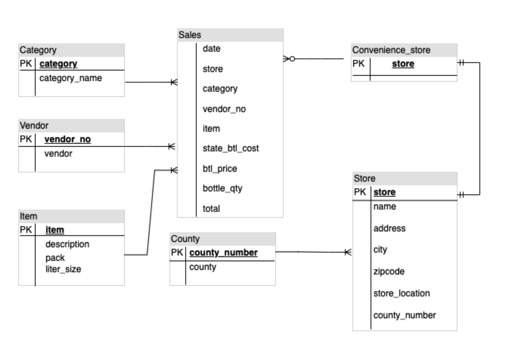


-------Resposta--------
## Entidades e Relacionamentos no DER:

O diagrama entidade-relacionamento (DER) descreve um banco de dados para gerenciar vendas em lojas de conveniência. Vamos analisar as entidades e seus relacionamentos:

**Entidades:**

* **Categoria (Category):**
    * **PK:** category (chave primária)
    * **Atributos:** category_name (nome da categoria)
* **Fornecedor (Vendor):**
    * **PK:** vendor_no (número do fornecedor - chave primária)
    * **Atributos:** vendor (nome do fornecedor)
* **Item:**
    * **PK:** item (chave primária)
    * **Atributos:** description (descrição), pack (embalagem), liter_size (tamanho em litros)
* **Condado (County):**
    * **PK:** county_number (número do condado - chave primária)
    * **Atributos:** county (nome do condado)
* **Loja (Store):**
    * **PK:** store (chave primária)
    * **Atributos:** name (nome), address (endereço), city (cidade), zipcode (CEP), store_location (localização da loja), county_number (número do conda

In [ ]:
image_er_url = "https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/er.png"
image_er = load_image_from_url(image_er_url)

prompt = "Documente as entidades e relacionamentos neste diagrama entidade relacionamento (DER)."

contents = [prompt, image_er]

# Use a more deterministic configuration with a low temperature
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=0.8,
    top_k=40,
    candidate_count=1,
    max_output_tokens=2048,
)

responses = multimodal_model.generate_content(
    contents,
    generation_config=generation_config,
    stream=True,
)

print("-------Prompt--------")
print_multimodal_prompt(contents)

print("\n-------Resposta--------")
for response in responses:
    print(response.text, end="")